  0%|          | 0/10000 [00:00<?, ?it/s]

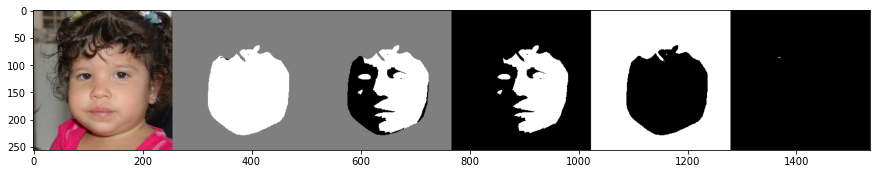

  0%|          | 1/10000 [00:00<24:35,  6.78it/s]

=> Image: 60000.jpg, IOU: 0.0007190106413574921


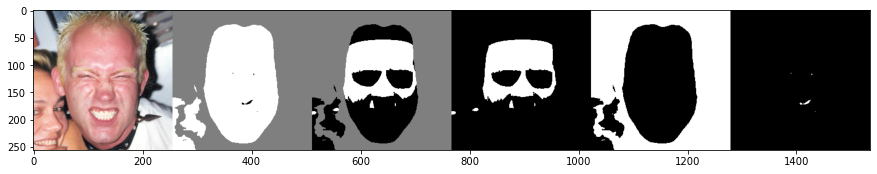

  0%|          | 2/10000 [00:00<23:09,  7.19it/s]

=> Image: 60001.jpg, IOU: 0.0038009675190048375


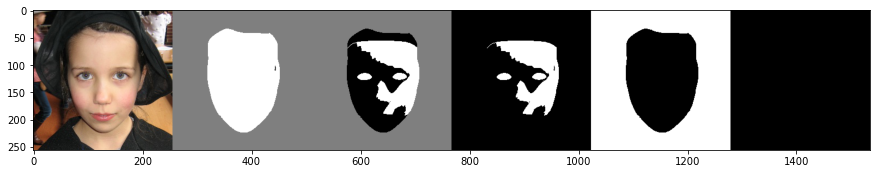

  0%|          | 3/10000 [00:00<22:30,  7.40it/s]

=> Image: 60002.jpg, IOU: 0.0


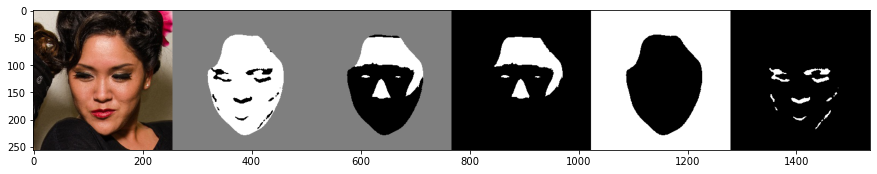

  0%|          | 4/10000 [00:00<22:13,  7.50it/s]

=> Image: 60003.jpg, IOU: 0.11009623226227369


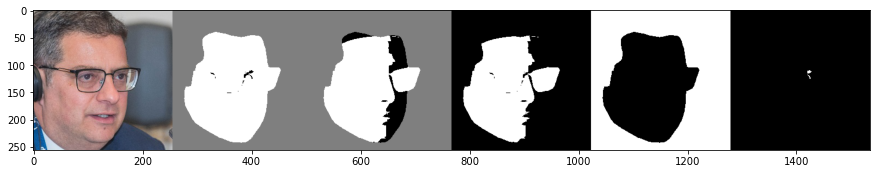

  0%|          | 5/10000 [00:00<21:58,  7.58it/s]

=> Image: 60004.jpg, IOU: 0.010002083767451552


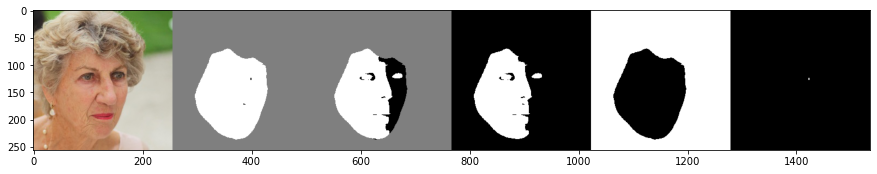

  0%|          | 6/10000 [00:00<22:02,  7.56it/s]

=> Image: 60005.jpg, IOU: 0.0021727322107550242


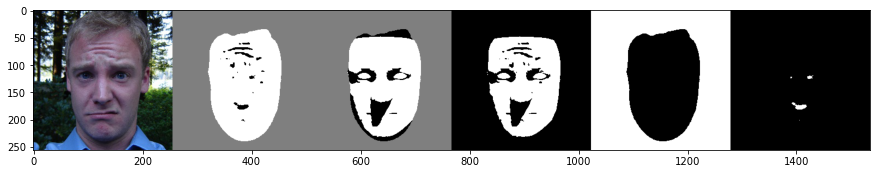

  0%|          | 6/10000 [00:00<25:56,  6.42it/s]

=> Image: 60006.jpg, IOU: 0.04714541476029441


In [46]:
import numpy as np
import torch as th
import glob, os, sys, tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

def create_image_grid(images, n_rows=1):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)
    return grid_image

def compute_IOU(img_path, plot=False):
    # img = '60065.png'
    img_name = img_path.split('/')[-1].split('.')[0]
    source_img_path = f'{img_path}'
    shadow_diff_path = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff/median5_5e-2/{set_}/{img_name}.png'
    shadow_mask_path = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_masks_t5e-1_forvis/{set_}/{img_name}.png'
    
    s_img = np.array(Image.open(source_img_path))
    # print(s_img.shape)
    sd_img = np.array(Image.open(shadow_diff_path))[..., None].repeat(3, axis=-1)
    sm_img = np.array(Image.open(shadow_mask_path))[..., None].repeat(3, axis=-1)
    # print(np.unique(sd_img), np.max(sd_img), np.min(sd_img), sd_img.shape)
    # print(np.unique(sm_img), np.max(sm_img), np.min(sm_img), sm_img.shape)
    
    intr = np.logical_and((sd_img == sm_img), (sm_img == 0))
    # union = np.logical_or((sm_img == 0), (sm_img == 255))
    union = np.logical_or((sm_img == 0), (sd_img == 0))
    
    tmp = [
        s_img,
        sd_img,
        sm_img,
        np.logical_and((sd_img == sm_img), (sm_img == 255)) * 255,
        np.logical_and((sd_img == sm_img), (sm_img == 127)) * 255,
        np.logical_and((sd_img == sm_img), (sm_img == 0)) * 255,
    ]
    
    # print("[#] IOU = ", np.sum(intr) / np.sum(union))
        
    if plot:
        plt.figure(figsize=(15, 15))
        plt.imshow(create_image_grid(tmp, 1), cmap='gray')
        plt.show()
        
    return np.sum(intr) / np.sum(union)
    
set_ = 'valid'
iou_df = pd.DataFrame(columns=['Image', 'IOU'])
count = 0
for p in tqdm.tqdm(sorted(glob.glob(f'/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/*.jpg'))):
    iou = compute_IOU(p, plot=True)
    iou = compute_IOU(p, plot=False)
    print(f'=> Image: {p.split("/")[-1]}, IOU: {iou}')
    iou_df = iou_df.append({'Image': p.split("/")[-1], 'IOU': iou.astype(np.float32)}, ignore_index=True)
    if count > 5:
        break
    count+=1
# iou_df.to_csv('./iou.csv', index=False)

# Creating the .json file

In [2]:
# Validation set (Test set)
# Hard Cast shadows (e.g., Nose)
import json, os
test_scen = {
    'L_accurate_nose_cs': [60065, 68598, 65284, 64113, 64691],
    'R_accurate_nose_cs': [64240, 68364, 63888 , 65112, 66312, 60351, 67641, 64889, 63919, 67487, 63849],
    'L_accurate_face_cs': [69739, 65708, 62747, 63124, 69267, 62704, 66025, 69128, 60362, 61614, 63134, 62615, 69274, 66344, 63872, 64970],
    'R_accurate_face_cs': [67841, 65262, 67887, 64381, 62747, 63668, 66553, 67366, 66376, 61035, 64584, 60055, 62801, 66407, 69380, 60223, 68280],
    'inaccurate_nose_cs': [62514, 66938, 69757, 62955, 66486, 63900, 61231, 62448, 68408, 67211, 68578, 65288, 63497, 63047, 66908, 61822, 65737, 63807, 68831],
    'inaccurate_face_cs': [66863, 69097, 60102, 66437, 62369, 62999, 66526, 60950, 60765, 67012, 60857, 65365, 68729, 65502, 62825, 60862, 65814, 64847],
    'accurate_diffuse': [61773, 63175, 69258, 61402, 60990],
    'inaccurate_diffuse': [62967, 69794, 63791, 65564, 61670]
}

targ_light = {
    'L_nose_cs': [60065, 68598],
    'R_nose_cs': [65112, 68364],
    'L_face_cs': [62448, 66890],
    'R_face_cs': [63790, 62999],
}
for scen in test_scen:
    print(f'[#] {scen}: {len(test_scen[scen])}')
    
pair_scen = [
    # Accurate nose
    ['L_accurate_nose_cs', 'R_nose_cs'],
    # ['L_accurate_nose_cs', 'L_nose_cs'],
    # ['R_accurate_nose_cs', 'R_nose_cs'],
    ['R_accurate_nose_cs', 'L_nose_cs'],
    # Accurate face
    ['L_accurate_face_cs', 'R_face_cs'],
    ['R_accurate_face_cs', 'L_face_cs'],
    # Inaccurate nose
    ['inaccurate_nose_cs', 'R_nose_cs'],
    ['inaccurate_nose_cs', 'L_nose_cs'],
    # Inaccurate face
    ['inaccurate_face_cs', 'R_face_cs'],
    ['inaccurate_face_cs', 'L_face_cs'],
    # Accurate diffuse
    ['accurate_diffuse', 'R_face_cs'],
    ['accurate_diffuse', 'L_face_cs'],
    ['accurate_diffuse', 'R_nose_cs'],
    ['accurate_diffuse', 'L_nose_cs'],
    # Inaccurate diffuse
    ['inaccurate_diffuse', 'R_face_cs'],
    ['inaccurate_diffuse', 'L_face_cs'],
    ['inaccurate_diffuse', 'R_nose_cs'],
    ['inaccurate_diffuse', 'L_nose_cs'],
]

def gen_json(pair_scene, fn):
    i = 0
    out = {"pair":{}}
    for pair in pair_scene:
        src_sj = test_scen[pair[0]]
        trg_sj = targ_light[pair[1]]
        for src in src_sj:
            for trg in trg_sj:
                out["pair"][f'pair{i}'] = {
                    "src": f'{src}.jpg',
                    "dst": f'{trg}.jpg'
                }
                i+=1
    
    with open(f'./{fn}.json', 'w') as f:
        json.dump(out, f, indent=4)
    
os.makedirs('./sample_json_cs', exist_ok=True)
# gen_json(pair_scen[0:1], fn='./sample_json_cs/L_accurate_nose_cs.json')
# gen_json(pair_scen[1:2], fn='./sample_json_cs/R_accurate_nose_cs.json')
# gen_json(pair_scen[2:3], fn='./sample_json_cs/L_accurate_face_cs.json')
# gen_json(pair_scen[3:4], fn='./sample_json_cs/R_accurate_face_cs.json')
# gen_json(pair_scen[4:6], fn='./sample_json_cs/inaccurate_nose_cs.json')
# gen_json(pair_scen[6:8], fn='./sample_json_cs/inaccurate_face_cs.json')
# gen_json(pair_scen[8:12], fn='./sample_json_cs/accurate_diffuse.json')
# gen_json(pair_scen[12:], fn='./sample_json_cs/inaccurate_diffuse.json')

[#] L_accurate_nose_cs: 5
[#] R_accurate_nose_cs: 11
[#] L_accurate_face_cs: 16
[#] R_accurate_face_cs: 17
[#] inaccurate_nose_cs: 19
[#] inaccurate_face_cs: 18
[#] accurate_diffuse: 5
[#] inaccurate_diffuse: 5


In [5]:
# Get all images in every set

imgs = []
for scen in test_scen:
    print(f'[#] {scen}: {len(test_scen[scen])}')
    for img in test_scen[scen]:
        imgs.append(f'{img}.jpg')

for scen in targ_light:
    print(f'[#] {scen}: {len(targ_light[scen])}')
    for img in targ_light[scen]:
        imgs.append(f'{img}.jpg')

i = 0
imgs = list(set(imgs))
out = {"pair":{}}
for src in imgs:
    out["pair"][f'pair{i}'] = {
        "src": f'{src}',
        "dst": f'60000.jpg'
    }
    i+=1

with open(f'./for_rotate_spiral.json', 'w') as f:
    json.dump(out, f, indent=4)

[#] L_accurate_nose_cs: 5
[#] R_accurate_nose_cs: 11
[#] L_accurate_face_cs: 16
[#] R_accurate_face_cs: 17
[#] inaccurate_nose_cs: 19
[#] inaccurate_face_cs: 18
[#] accurate_diffuse: 5
[#] inaccurate_diffuse: 5
[#] L_nose_cs: 2
[#] R_nose_cs: 2
[#] L_face_cs: 2
[#] R_face_cs: 2
